In [1]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__, keras.__version__)

2.3.1 2.4.0


## Transfer Learning

Assuming we have trained 8 of the 10 classes in the fashion mnist data. The model performs pretty well. Now we need to create a new model which predicts just two classes:

Model A:
"T-shirt/pop", "Trouser", "Pullover", "Dresss", "Coat", "Sandal", "Shirt", "Sneaker"

Model B:
"Bag", "Ankle boot"

we should be able to utilise transfer learning

### Downloading Fashion mnist data

In [8]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()


### Data Prep

In [13]:
X_train_A = X_train_full[y_train_full < 8]
y_train_A = y_train_full[y_train_full < 8]

X_test_A = X_test[y_test < 8]
y_test_A = y_test[y_test < 8]


X_train_B = X_train_full[y_train_full >=8]
y_train_B = (y_train_full[y_train_full >=8] == 8).astype(int)


X_test_B = X_test[y_test >=8]
y_test_B = (y_test[y_test >=8] == 8).astype(int)


In [4]:
class_names_A = ["T-shirt/pop", "Trouser", "Pullover", "Dresss", "Coat",
                 "Sandal", "Shirt", "Sneaker"]
class_names_B = ["Bag", "Ankle boot"]

## Build and train Model A 


In this case for simplicity, we will just use a simple sequencial model with dense hidden layers.

In [7]:
NUM_EPOCHS = 20

from tensorflow.keras import activations, layers, initializers, callbacks, models
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU, BatchNormalization, ReLU, ELU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es_cb = EarlyStopping(patience=3, monitor='val_loss') # early stopping at min loss
md_cb = ModelCheckpoint("f_mnist_model_A.h5", save_best_only=True)

model = Sequential([
        Flatten(input_shape=[28, 28]),
        BatchNormalization(),
        Dense(300, activation = "relu"),
        Dense(300, activation = "relu"),
        Dense(300, activation = "relu"),
        Dense(8, activation = "softmax")
])

model.compile(optimizer = "SGD", loss = "sparse_categorical_crossentropy", metrics = "accuracy")

history = model.fit(X_train_A, y_train_A, epochs=NUM_EPOCHS, validation_split = 0.2, callbacks=[es_cb, md_cb], verbose = True)

Epoch 1/20
1200/1200 [==============================] - 23s 20ms/step - loss: 0.5985 - accuracy: 0.7805 - val_loss: 0.4431 - val_accuracy: 0.8408
Epoch 2/20
1200/1200 [==============================] - 23s 19ms/step - loss: 0.4283 - accuracy: 0.8394 - val_loss: 0.4001 - val_accuracy: 0.8562
Epoch 3/20
1200/1200 [==============================] - 24s 20ms/step - loss: 0.3892 - accuracy: 0.8551 - val_loss: 0.3775 - val_accuracy: 0.8596
Epoch 4/20
1200/1200 [==============================] - 24s 20ms/step - loss: 0.3625 - accuracy: 0.8637 - val_loss: 0.3756 - val_accuracy: 0.8697
Epoch 5/20
1200/1200 [==============================] - 24s 20ms/step - loss: 0.3409 - accuracy: 0.8722 - val_loss: 0.3786 - val_accuracy: 0.8695
Epoch 6/20
1200/1200 [==============================] - 24s 20ms/step - loss: 0.3235 - accuracy: 0.8773 - val_loss: 0.3913 - val_accuracy: 0.8696
Epoch 7/20
1200/1200 [==============================] - 24s 20ms/step - loss: 0.3056 - accuracy: 0.8860 - val_loss: 0.3879 -

In [8]:
model.evaluate(X_test_A, y_test_A)
model.summary()

250/250 [==============================] - 2s 9ms/step - loss: 0.4109 - accuracy: 0.8514
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_4 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_6 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 2408      
Total params: 421,644
Trainable

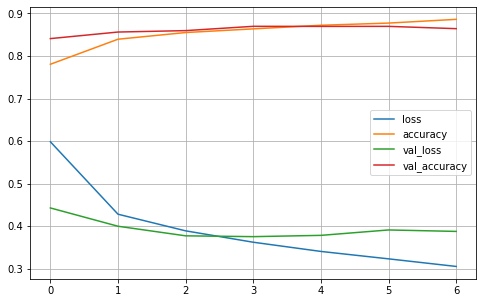

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

## Transfer Learning with Model B

Remember model B is a binary classifier but the input should be the same. 


In [3]:
from tensorflow.keras import activations, layers, initializers, callbacks, models
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU, BatchNormalization, ReLU, ELU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model_A = tf.keras.models.load_model('f_mnist_model_A.h5')

# we don't want to impact weights of model A. therefore we make a clone. 
# clone model does not copy weights, so we have to set the weights again

model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(Dense(1, activation = "sigmoid"))

model_B_on_A.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_4 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_5 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_6 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 419,537
Trainable params: 417,969
Non-trainable params: 1,568
______________________________________________

## Freeze layers

As the first few layers will not be initialled randomly, therefore will be large errors. The approach is to freeze the **reused** layers for the first few epoches, giving new layer some time to learn reasonable weights.

In [15]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False
    
model_B_on_A.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ['accuracy']) # any freeze/unfreeze requires the model to be recompiled

In [16]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs = 4, validation_split=0.2)

Epoch 1/4
300/300 [==============================] - 0s 1ms/step - loss: 0.2036 - accuracy: 0.9371 - val_loss: 0.0992 - val_accuracy: 0.9758
Epoch 2/4
300/300 [==============================] - 0s 1ms/step - loss: 0.0834 - accuracy: 0.9800 - val_loss: 0.0702 - val_accuracy: 0.9850
Epoch 3/4
300/300 [==============================] - 0s 1ms/step - loss: 0.0651 - accuracy: 0.9843 - val_loss: 0.0601 - val_accuracy: 0.9871
Epoch 4/4
300/300 [==============================] - 0s 1ms/step - loss: 0.0556 - accuracy: 0.9861 - val_loss: 0.0539 - val_accuracy: 0.9875


In [17]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
    
model_B_on_A.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ['accuracy']) # any freeze/unfreeze requires the model to be recompiled

history = model_B_on_A.fit(X_train_B, y_train_B, epochs = 15, validation_split=0.2)

Epoch 1/15
300/300 [==============================] - 1s 3ms/step - loss: 0.0338 - accuracy: 0.9910 - val_loss: 0.0135 - val_accuracy: 0.9967
Epoch 2/15
300/300 [==============================] - 1s 3ms/step - loss: 0.0150 - accuracy: 0.9966 - val_loss: 0.0096 - val_accuracy: 0.9979
Epoch 3/15
300/300 [==============================] - 1s 3ms/step - loss: 0.0108 - accuracy: 0.9972 - val_loss: 0.0085 - val_accuracy: 0.9983
Epoch 4/15
300/300 [==============================] - 1s 3ms/step - loss: 0.0131 - accuracy: 0.9958 - val_loss: 0.0080 - val_accuracy: 0.9983
Epoch 5/15
300/300 [==============================] - 1s 3ms/step - loss: 0.0101 - accuracy: 0.9962 - val_loss: 0.0060 - val_accuracy: 0.9983
Epoch 6/15
300/300 [==============================] - 1s 3ms/step - loss: 0.0080 - accuracy: 0.9975 - val_loss: 0.0055 - val_accuracy: 0.9987
Epoch 7/15
300/300 [==============================] - 1s 3ms/step - loss: 0.0090 - accuracy: 0.9974 - val_loss: 0.0050 - val_accuracy: 0.9987
Epoch 

In [18]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.0133 - accuracy: 0.9970


[0.01327226310968399, 0.996999979019165]